In [1]:
!pip install flask
!pip install pyserial
!pip install opencv-python
!pip install nbimporter
!pip install torch torchaudio torchvision
!jupyter nbconvert --to script text_processing.ipynb
!jupyter nbconvert --to script camera_operation.ipynb
!jupyter nbconvert --to script braille_translate.ipynb

[NbConvertApp] Converting notebook text_processing.ipynb to script
[NbConvertApp] Writing 5212 bytes to text_processing.py
[NbConvertApp] Converting notebook camera_operation.ipynb to script
[NbConvertApp] Writing 675 bytes to camera_operation.py
[NbConvertApp] Converting notebook braille_translate.ipynb to script
[NbConvertApp] Writing 6609 bytes to braille_translate.py


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.18:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Jun/2024 22:52:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.23226241180771945 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.8919097081228284 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.7625197302944349 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.7289243480092105 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.5419171988425979 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.3042692531695512 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.8492673776171855 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.044066503547096625 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:52:59] "GET /video?rand=0.5226054600924976 HTTP/1.1" 200 -
12

===============  Received from Arduino ->  Take Picture   ===============
< 1 - 이미지 촬영 >
1-1 이미지 촬영 진행 중입니다.
1-2 이미지 촬영이 완료되었습니다.
이미지 경로 : C:\Users\peter\capstone\camera\20240605-225302.jpg

< 2 - 텍스트 인식 >
2-1 이미지 내 텍스트 인식을 진행 중입니다.


127.0.0.1 - - [05/Jun/2024 22:53:02] "GET /video?rand=0.9713996130682718 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:02] "GET /video?rand=0.616477249572789 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /video?rand=0.7597407880288858 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /video?rand=0.09253624459864618 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /video?rand=0.9842956281291704 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /video?rand=0.9204306639359661 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /video?rand=0.9907416021353697 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /video?rand=0.4455721844304472 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:03] "GET /arduino_received_message HTTP/1.1" 200 -
[2024-06-05 22:53:03,533] ERROR in app: Exception on /labelled_image [GET]
Traceback (most recent call last):
  File "C:\Users\peter\anaconda3\envs\capstone\Lib\site-packages\flask\app.py", line 1473, in 

2-2 이미지 내 텍스트 인식을 완료했습니다.


127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.17805001783499885 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.030656385636600003 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.5510173622803565 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.1938534655896953 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.6847617718809307 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.19948192592276337 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.5613304469418912 HTTP/1.1" 200 -


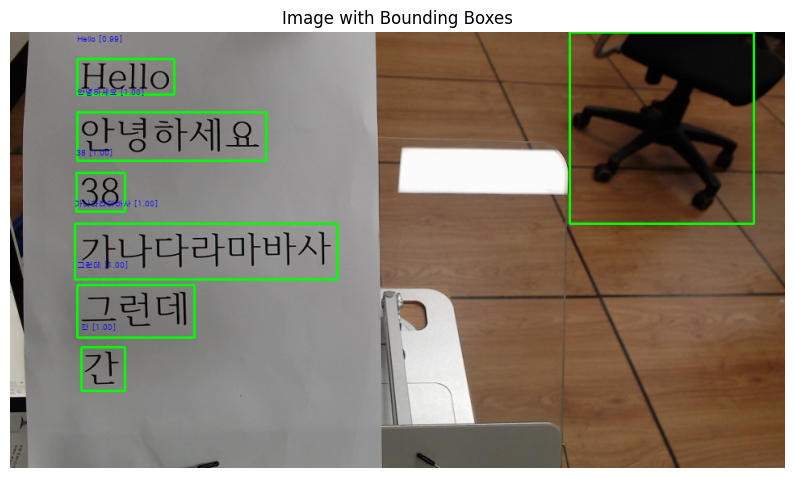

127.0.0.1 - - [05/Jun/2024 22:53:19] "GET /video?rand=0.32843648302937 HTTP/1.1" 200 -


2-3 이미지 내 텍스트 라벨링 및 저장을 완료했습니다.
2-4 텍스트 철자 및 문법 교정을 진행 중입니다. 
한글은 아직 정의되지 않았습니다.


127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.10495612036045299 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.558367411297614 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.5782160759754278 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.23395367956206048 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.09916504775752322 HTTP/1.1" 200 -


한글은 아직 정의되지 않았습니다.
한글은 아직 정의되지 않았습니다.
한글은 아직 정의되지 않았습니다.
2-5 철자 및 문법 교정을 완료했습니다.
인식된 텍스트 >>>  ['Hello', '안녕하세요', '38', '가나다라마바사', '그런데', '간']
< 3 - 텍스트 점자로 변환 >
텍스트를 점자로 변환 중입니다...
점자 변환이 완료됐습니다.
점자 텍스트 >>>  ['3603421270705226', '4322114724035435', '371142', '4511210243120470', '1054', '4522']


127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.9595495272144128 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.057410226418037835 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.4891513018776472 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.23258737102431937 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.45331969240075876 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.02464440920657096 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:20] "GET /video?rand=0.29139974380597966 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:21] "GET /video?rand=0.7225339357426708 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:21] "GET /video?

===============  Received from Arduino ->  Next   ===============
단어: Hello
점자: 3603421270705226


127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.4405023014528777 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.10881860021408207 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.1500537756193301 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.1760075170253632 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.2380463143775231 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.211444038838557 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.9840704133924065 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=0.43750104205773277 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:29] "GET /video?rand=

===============  Received from Arduino ->  Next   ===============
단어: 안녕하세요
점자: 4322114724035435


127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /video?rand=0.17892192430255238 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /video?rand=0.587635455068757 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /video?rand=0.05141159451801269 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /video?rand=0.18169983745182572 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:34] "GET /video?rand=0.6579985077699517 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:35] "GET /video?rand=0.47407352909400524 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:35] "GET /video?rand=0.7789100512322327 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:35] "GET /video?rand=0.05858417636278257 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:35] "GET /video?ra

===============  Received from Arduino ->  Next   ===============
단어: 38
점자: 371142


127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.8264025863340145 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.5297172573940578 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.5288256199376482 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.510488286406898 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.04751864880695189 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.7175381450026752 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.08143814618920264 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:53:43] "GET /video?rand=0.7393341204968

===============  Received from Arduino ->  Next   ===============
단어: 가나다라마바사
점자: 4511210243120470


127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.31316924587846584 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.8579489814356862 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.022319263894399866 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.09003374404006248 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.6354591474368951 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.9222321928067652 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:52] "GET /video?rand=0.20281892890088415 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:53] "GET /video?rand=0.12275847819170038 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2024 22:54:53] "GET /video?

In [11]:
from flask import Flask, render_template, Response, request, jsonify
import serial
import time
import os
import cv2
import threading
import subprocess
import nbimporter
import io
from PIL import Image
from camera_operation import taking_picture
from text_processing import text_correction, text_detection
from braille_translate import text_to_braille

app = Flask(__name__)

# 연결할 시리얼 포트와 baudrate 설정
ser = serial.Serial('COM7', 9600)

# 변수 초기화
camera = cv2.VideoCapture(1)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1080) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
recognized_texts_global = [] # 인식된 텍스트 리스트
current_text_index = -1 # 리스트 위치 변수
braille_texts = []
labelled_img_path = None
word = ""
last_arduino_message = ""  # Arduino로부터 받은 마지막 메시지를 저장하는 변수
current_status_message = "" # 현재 진행상황

def read_from_port(ser):
    global recognized_texts_global, current_text_index, braille_texts, labelled_img_path, word, last_arduino_message, current_status_message
    
    while True:
        reading = ser.readline().decode().strip()
        current_status_message = "촬영 버튼을 누르기 전 책을 화면과 같이 왼쪽 페이지와 오른쪽 페이지를 구분할 수 있도록 배치하십시오. 만약 책이 아니라 문서를 인식하고 싶으시다면 왼쪽 페이지 부분에 문서를 배치해주시기 바랍니다."
        
        print("===============  Received from Arduino -> ", reading, "  ===============")
        if reading == "Take Picture":
            # 메시지 업데이트
            last_arduino_message = "촬영 버튼"
            
            # 1 - 이미지 촬영
            print("< 1 - 이미지 촬영 >")
            img_path = taking_picture(camera)

            # 널값인지 검사
            if img_path is None:
                current_status_message = "[Error] 이미지 촬영에 실패했습니다. 카메라를 확인하시고 다시 촬영해주세요."
                continue
            else:
                current_status_message = "이미지 촬영이 완료됐습니다. 텍스트 인식을 진행합니다."
            
            # 2 - 텍스트 인식
            print("< 2 - 텍스트 인식 >")
            recognized_texts, labelled_img_path = text_detection(img_path)
                
            # 인식된 텍스트 처리
            words_list = [word for text in recognized_texts for word in text.split()]
            try:
                corrected_texts = text_correction(words_list)
            except ValueError as e:
                print(f"예외 발생: {e}")
                continue
            
            filtered_texts = [text for text in corrected_texts if text.strip()]
            #filtered_texts = [text for text in words_list if text.strip()]
            print("인식된 텍스트 >>> ", filtered_texts)
            recognized_texts_global = filtered_texts  # 새로운 텍스트로 업데이트
            current_text_index = -1  # 새로운 텍스트 리스트로 업데이트되면 인덱스 초기화
            current_status_message = "텍스트 인식이 완료됐습니다. " + ", ".join([text for text in recognized_texts_global])
            
            # 3 - 텍스트를 점자로 변환하여 저장
            print("< 3 - 텍스트 점자로 변환 >")
            braille_texts = text_to_braille(recognized_texts_global)
            print("점자 텍스트 >>> ", braille_texts)
            current_status_message = "점자 변환이 완료됐습니다. 다음 단어 출력 버튼과 이전 버튼 출력을 눌러 점자 확인이 가능합니다."
            
        elif reading == "Next":
            # 메시지 업데이트
            current_status_message = "다음 단어 출력 버튼이 입력됐습니다."
            last_arduino_message = "다음 단어 출력 버튼"
            next_text()
            
        elif reading == "Previous":
            # 메시지 업데이트
            current_status_message = "이전 단어 출력 버튼이 입력됐습니다."
            last_arduino_message = "이전 단어 출력 버튼"
            previous_text()

def next_text():
    global current_text_index, word, current_status_message, recognized_texts_global, braille_texts
    
    if len(recognized_texts_global) == 0:
        current_status_message = "리스트가 비어있습니다. 촬영부터 진행해주세요."
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index < len(recognized_texts_global) - 1:
        current_text_index += 1
        word = recognized_texts_global[current_text_index]
        send_text_to_arduino(word, braille_texts[current_text_index])
    else:
        current_status_message = "인식된 텍스트를 다 읽었습니다."
        print("리스트의 끝점입니다.")

def previous_text():
    global current_text_index, word, current_status_message, recognized_texts_global, braille_texts
    
    if len(recognized_texts_global) == 0:
        current_status_message = "리스트가 비어있습니다. 촬영부터 진행해주세요."
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index > 0:
        current_text_index -= 1
        word = recognized_texts_global[current_text_index]
        send_text_to_arduino(word, braille_texts[current_text_index])
        
    else:
        current_status_message = "첫 번째 텍스트이므로 그 이전 단어가 없습니다."
        print("리스트의 시작점입니다.")

def send_text_to_arduino(text, braille):
    print("단어:", text)
    print("점자:", braille)
    ser.write((braille + "\n").encode())

def generate_frames():
    while True:
        success, frame = camera.read()  # 카메라로부터 프레임 읽기
        if not success:
            break
        else:
            # 프레임 크기 가져오기
            height, width, _ = frame.shape

            # 중앙선 그리기
            center_x = width // 2
            cv2.line(frame, (center_x, 0), (center_x, height), (0, 255, 0), 2)

            # 텍스트 출력
            cv2.putText(frame, 'Left Page', (50, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.putText(frame, 'Right Page', (center_x + 400, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # JPEG 형식으로 인코딩
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()

            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
            
@app.route('/')
def index():
    return render_template('final_index.html')

@app.route('/video')
def video():
    return Response(generate_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/labelled_image')
def labelled_image():
    img = cv2.imread(labelled_img_path)
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_io = io.BytesIO()
    img_pil.save(img_io, 'JPEG', quality=70)
    img_io.seek(0)
    return Response(img_io.getvalue(), mimetype='image/jpeg')

@app.route('/arduino_received_message')
def arduino_received_message():
    # Arduino로부터 받은 마지막 메시지를 반환합니다.
    return jsonify({"message": last_arduino_message})

@app.route('/send_to_arduino')
def send_to_arduino():
    # Arduino로 보낸 문자열 반환
    return jsonify({"message": word})

@app.route('/current_status')
def get_current_status():
    # 현재 진행 상황을 출력
    return jsonify({"message": current_status_message})
    
if __name__ == '__main__':
    thread = threading.Thread(target=read_from_port, args=(ser,))
    thread.start()
    app.run(debug=False, host='0.0.0.0', port=5000) 